<a href="https://colab.research.google.com/github/plaban1981/Langchain_usecases/blob/main/Building_a_multidocument_agentic_RAG_with_LLamaIndex_GROQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%writefile requirements.txt
llama-index
llama-index-llms-huggingface
llama-index-embeddings-fastembed
fastembed
Unstructured[md]
chromadb
llama-index-vector-stores-chroma
llama-index-llms-groq
einops
accelerate
sentence-transformers


Writing requirements.txt


## Install Required Dependencies

In [3]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 34.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of fastembed to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of fastembed to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to

In [ ]:
!pip install -q llama-index-llms-openai

## Download Documents to be processed

In [4]:
!mkdir data

In [43]:
! wget "https://arxiv.org/pdf/1810.04805.pdf" -O ./data/BERT_arxiv.pdf
! wget "https://arxiv.org/pdf/2005.11401" -O ./data/RAG_arxiv.pdf
! wget "https://arxiv.org/pdf/2310.11511" -O ./data/self_rag_arxiv.pdf
! wget "https://arxiv.org/pdf/2401.15884" -O ./data/crag_arxiv.pdf

--2024-05-11 15:51:49--  https://arxiv.org/pdf/1810.04805.pdf
Resolving arxiv.org (arxiv.org)... 151.101.131.42, 151.101.3.42, 151.101.67.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.131.42|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://arxiv.org/pdf/1810.04805 [following]
--2024-05-11 15:51:49--  http://arxiv.org/pdf/1810.04805
Connecting to arxiv.org (arxiv.org)|151.101.131.42|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 775166 (757K) [application/pdf]
Saving to: ‘./data/BERT_arxiv.pdf’

./data/BERT_arxiv.p 100%[===================>] 757.00K  --.-KB/s    in 0.02s   

2024-05-11 15:51:49 (43.8 MB/s) - ‘./data/BERT_arxiv.pdf’ saved [775166/775166]

--2024-05-11 15:51:49--  https://arxiv.org/pdf/2005.11401
Resolving arxiv.org (arxiv.org)... 151.101.131.42, 151.101.3.42, 151.101.67.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.131.42|:443... connected.
HTTP request sent, awaiting response... 200 O

## Import Required Dependencies

In [23]:
from llama_index.core import SimpleDirectoryReader,VectorStoreIndex,SummaryIndex
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.tools import FunctionTool,QueryEngineTool
from llama_index.core.vector_stores import MetadataFilters,FilterCondition
from typing import List,Optional

In [7]:
import  nest_asyncio
nest_asyncio.apply()

## Read Data

In [124]:
documents = SimpleDirectoryReader(input_files = ['./data/self_rag_arxiv.pdf']).load_data()

In [125]:
len(documents)

30

## Display Metadata

In [126]:
documents[0].metadata

{'page_label': '1',
 'file_name': 'self_rag_arxiv.pdf',
 'file_path': 'data/self_rag_arxiv.pdf',
 'file_type': 'application/pdf',
 'file_size': 1405127,
 'creation_date': '2024-05-11',
 'last_modified_date': '2023-10-19'}

## Split the documents into chunks

In [127]:
splitter = SentenceSplitter(chunk_size=1024,chunk_overlap=100)
nodes = splitter.get_nodes_from_documents(documents)
print(f"Length of nodes : {len(nodes)}")
print(f"get the content for node 0 :{nodes[0].get_content(metadata_mode='all')}")

Length of nodes : 43
get the content for node 0 :page_label: 1
file_name: self_rag_arxiv.pdf
file_path: data/self_rag_arxiv.pdf
file_type: application/pdf
file_size: 1405127
creation_date: 2024-05-11
last_modified_date: 2023-10-19

Preprint.
SELF-RAG: LEARNING TO RETRIEVE , GENERATE ,AND
CRITIQUE THROUGH SELF-REFLECTION
Akari Asai†, Zeqiu Wu†, Yizhong Wang†§, Avirup Sil‡, Hannaneh Hajishirzi†§
†University of Washington§Allen Institute for AI‡IBM Research AI
{akari,zeqiuwu,yizhongw,hannaneh }@cs.washington.edu ,avi@us.ibm.com
ABSTRACT
Despite their remarkable capabilities, large language models (LLMs) often produce
responses containing factual inaccuracies due to their sole reliance on the paramet-
ric knowledge they encapsulate. Retrieval-Augmented Generation (RAG), an ad
hoc approach that augments LMs with retrieval of relevant knowledge, decreases
such issues. However, indiscriminately retrieving and incorporating a fixed number
of retrieved passages, regardless of whether retrieval 

## Instantiate the vectorstore

In [139]:
import chromadb
db = chromadb.PersistentClient(path="./chroma_db_mistral")
chroma_collection = db.get_or_create_collection("multidocument-agent")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

## Instantiate Embedding Model

In [19]:
from llama_index.embeddings.fastembed import FastEmbedEmbedding
from llama_index.core import Settings
#
embed_model = FastEmbedEmbedding(model_name="BAAI/bge-small-en-v1.5")
#
Settings.embed_model = embed_model
#
Settings.chunk_size = 1024
#

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

## Instantiate the LLM

In [66]:
from google.colab import userdata
from llama_index.llms.groq import Groq
GROQ_API_KEY = userdata.get('GROQ_API_KEY')
#
llm = Groq(model="gemma-7b-it", api_key=GROQ_API_KEY)
Settings.llm = llm
Settings.chunk_size = 1024

In [155]:
from llama_index.llms.openai import OpenAI
#
llm =  OpenAI(model="gpt-3.5-turbo",api_key= userdata.get('OPENAI_API_KEY'),temperature=0)
Settings.llm = llm
Settings.chunk_size = 1024

In [137]:

#instantiate Vectorstore
name = "BERT_arxiv"
vector_index = VectorStoreIndex(nodes,storage_context=storage_context)
vector_index.storage_context.vector_store.persist(persist_path="/content/chroma_db")
#
# Define Vectorstore Autoretrieval tool
def vector_query(query:str,page_numbers:Optional[List[str]]=None)->str:
  '''
  perform vector search over index on
  query(str): query string needs to be embedded
  page_numbers(List[str]): list of page numbers to be retrieved,
                          leave blank if we want to perform a vector search over all pages
  '''
  page_numbers = page_numbers or []
  metadata_dict = [{"key":'page_label',"value":p} for p in page_numbers]
  #
  query_engine = vector_index.as_query_engine(similarity_top_k =2,
                                              filters = MetadataFilters.from_dicts(metadata_dict,
                                                                                    condition=FilterCondition.OR)
                                              )
  #
  response = query_engine.query(query)
  return response
#
#llamiondex FunctionTool wraps any python function we feed it
vector_query_tool = FunctionTool.from_defaults(name=f"vector_tool_{name}",
                                              fn=vector_query)
# Prepare Summary Tool
summary_index = SummaryIndex(nodes)
summary_query_engine = summary_index.as_query_engine(response_mode="tree_summarize",
                                                      se_async=True,)
summary_query_tool = QueryEngineTool.from_defaults(name=f"summary_tool_{name}",
                                                    query_engine=summary_query_engine,
                                                  description=("Use ONLY IF you want to get a holistic summary of the documents."
                                              "DO NOT USE if you have specified questions over the documents."))

In [131]:
!pip install llama-index-llms-mistralai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.27.0
    Uninstalling httpx-0.27.0:
      Successfully uninstalled httpx-0.27.0


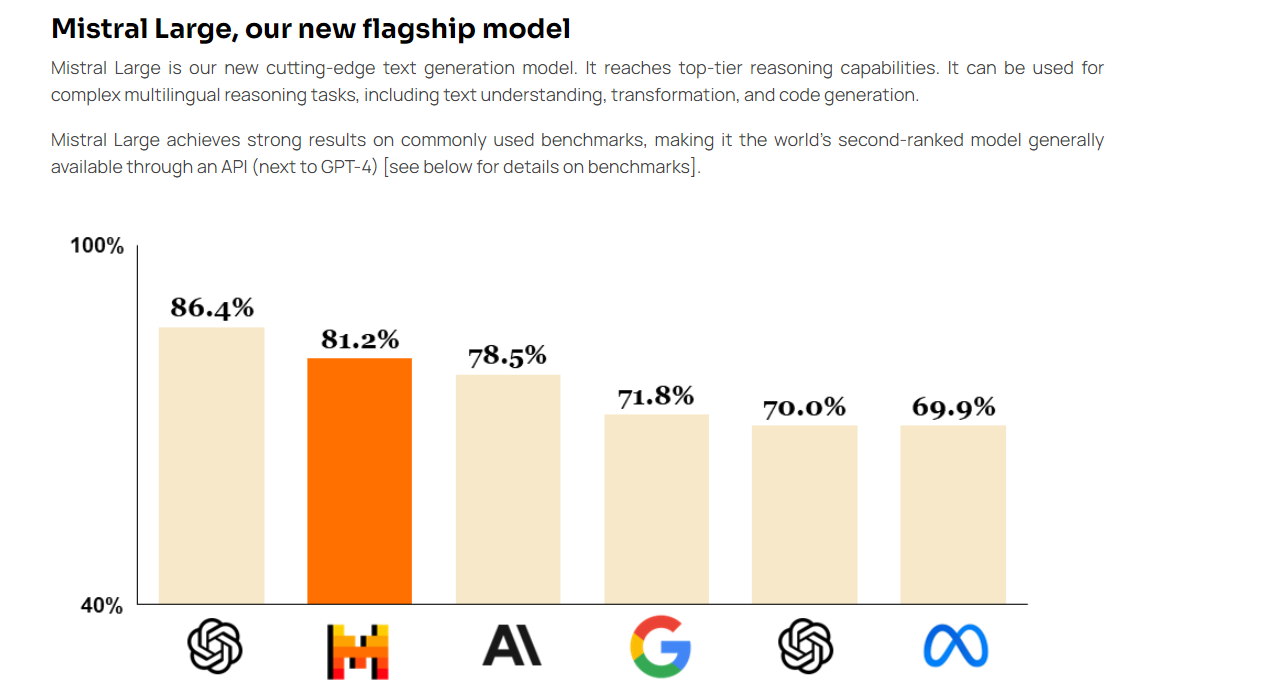

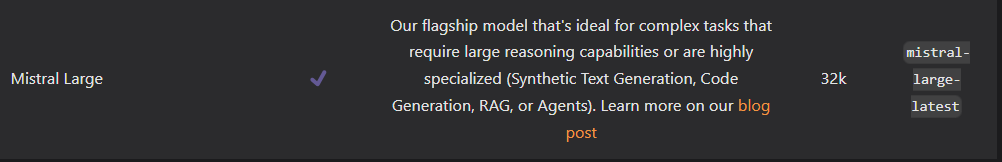

#### Mistral Large comes with new capabilities and strengths:

* It is natively fluent in English, French, Spanish, German, and Italian, with a nuanced understanding of grammar and cultural context.

* Its 32K tokens context window allows precise information recall from large documents.

* Its precise instruction-following enables developers to design their moderation policies – we used it to set up the system-level moderation of le Chat.

* It is natively capable of **function calling**. This, along with constrained output mode, implemented on la Plateforme, enables application development and tech stack modernisation at scale.

In [135]:
from llama_index.llms.mistralai import MistralAI
os.environ["MISTRAL_API_KEY"] = userdata.get("MISTRAL_API_KEY")
llm = MistralAI(model="mistral-large-latest")

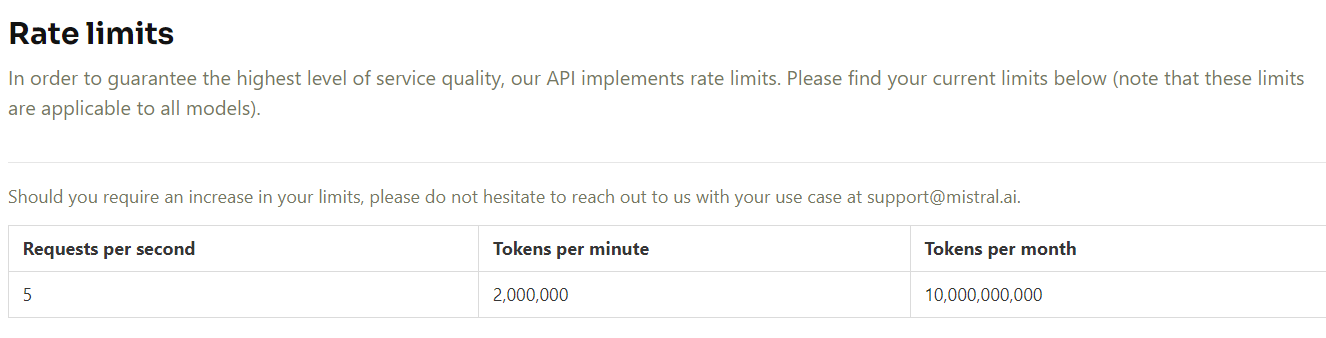

In [138]:
response = llm.predict_and_call([vector_query_tool],
                                "Summarize the content in page number 2",
                                verbose=True)

=== Calling Function ===
Calling function: vector_tool_BERT_arxiv with args: {"query": "summarize content", "page_numbers": ["2"]}
=== Function Output ===
The content discusses the use of RAG models for knowledge-intensive generation tasks, such as MS-MARCO and Jeopardy question generation, showing that the models produce more factual, specific, and diverse responses compared to a BART baseline. The models also perform well in FEVER fact verification, achieving results close to state-of-the-art pipeline models. Additionally, the models demonstrate the ability to update their knowledge as the world changes by replacing the non-parametric memory.


## Helper function to generate Vectorstore Tool and Summary tool for all the documents

In [103]:
def get_doc_tools(file_path:str,name:str)->str:
  '''
  get vector query and sumnmary query tools from a document
  '''
  #load documents
  documents = SimpleDirectoryReader(input_files = [file_path]).load_data()
  print(f"length of nodes")
  splitter = SentenceSplitter(chunk_size=1024,chunk_overlap=100)
  nodes = splitter.get_nodes_from_documents(documents)
  print(f"Length of nodes : {len(nodes)}")
  #instantiate Vectorstore
  vector_index = VectorStoreIndex(nodes,storage_context=storage_context)
  vector_index.storage_context.vector_store.persist(persist_path="/content/chroma_db")
  #
  # Define Vectorstore Autoretrieval tool
  def vector_query(query:str,page_numbers:Optional[List[str]]=None)->str:
    '''
    perform vector search over index on
    query(str): query string needs to be embedded
    page_numbers(List[str]): list of page numbers to be retrieved,
                            leave blank if we want to perform a vector search over all pages
    '''
    page_numbers = page_numbers or []
    metadata_dict = [{"key":'page_label',"value":p} for p in page_numbers]
    #
    query_engine = vector_index.as_query_engine(similarity_top_k =2,
                                                filters = MetadataFilters.from_dicts(metadata_dict,
                                                                                     condition=FilterCondition.OR)
                                                )
    #
    response = query_engine.query(query)
    return response
  #
  #llamiondex FunctionTool wraps any python function we feed it
  vector_query_tool = FunctionTool.from_defaults(name=f"vector_tool_{name}",
                                                fn=vector_query)
  # Prepare Summary Tool
  summary_index = SummaryIndex(nodes)
  summary_query_engine = summary_index.as_query_engine(response_mode="tree_summarize",
                                                       se_async=True,)
  summary_query_tool = QueryEngineTool.from_defaults(name=f"summary_tool_{name}",
                                                     query_engine=summary_query_engine,
                                                    description=("Use ONLY IF you want to get a holistic summary of the documents."
                                                "DO NOT USE if you have specified questions over the documents."))
  return vector_query_tool,summary_query_tool



## Prepare a input list with specified document names

In [140]:
import os
root_path = "/content/data"
file_name = []
file_path = []
for files in os.listdir(root_path):
  if file.endswith(".pdf"):
    file_name.append(files.split(".")[0])
    file_path.append(os.path.join(root_path,file))
#

In [141]:
file_name

['self_rag_arxiv', 'crag_arxiv', 'RAG_arxiv', '', 'BERT_arxiv']

In [142]:
file_path

['/content/data/BERT_arxiv.pdf',
 '/content/data/BERT_arxiv.pdf',
 '/content/data/BERT_arxiv.pdf',
 '/content/data/BERT_arxiv.pdf',
 '/content/data/BERT_arxiv.pdf']

## Generate the vectortool and summary tool for each documents

In [143]:
papers_to_tools_dict = {}
for name,filename in zip(file_name,file_path):
  vector_query_tool,summary_query_tool = get_doc_tools(filename,name)
  papers_to_tools_dict[name] = [vector_query_tool,summary_query_tool]

length of nodes
Length of nodes : 28
length of nodes
Length of nodes : 28
length of nodes
Length of nodes : 28
length of nodes
Length of nodes : 28
length of nodes
Length of nodes : 28


## Get the tools in a flat list

In [90]:
papers_to_tools_dict

{'self_rag_arxiv.pdf': [<llama_index.core.tools.function_tool.FunctionTool at 0x7a3ea875a6b0>,
 'crag_arxiv.pdf': [<llama_index.core.tools.function_tool.FunctionTool at 0x7a3dca3e55a0>,
 'RAG_arxiv.pdf': [<llama_index.core.tools.function_tool.FunctionTool at 0x7a3dca36af50>,
 'BERT_arxiv.pdf': [<llama_index.core.tools.function_tool.FunctionTool at 0x7a3de00a85b0>,
  <llama_index.core.tools.function_tool.FunctionTool at 0x7a3dca36a3b0>]}

In [144]:
initial_tools = [t for f in file_name for t in papers_to_tools_dict[f]]
initial_tools

## Perform RAG over the set of tools in order to solv the issue  related to too many tool selections


In [145]:
from llama_index.core import VectorStoreIndex
from llama_index.core.objects import ObjectIndex
#
obj_index = ObjectIndex.from_objects(initial_tools,index_cls=VectorStoreIndex)
#

## Setup the object index as retriever

In [146]:
obj_retriever = obj_index.as_retriever(similarity_top_k=2)
tools = obj_retriever.retrieve("compare and contrast the papers self rag and corrective rag")

In [108]:
tools

In [147]:
tools[0].metadata

ToolMetadata(description='Use ONLY IF you want to get a holistic summary of the documents.DO NOT USE if you have specified questions over the documents.', name='summary_tool_self_rag_arxiv', fn_schema=<class 'llama_index.core.tools.types.DefaultToolFnSchema'>, return_direct=False)

In [148]:
tools[1].metadata

ToolMetadata(description='vector_tool_self_rag_arxiv(query: str, page_numbers: Optional[List[str]] = None) -> str\n\n    perform vector search over index on\n    query(str): query string needs to be embedded\n    page_numbers(List[str]): list of page numbers to be retrieved,\n                            leave blank if we want to perform a vector search over all pages\n    ', name='vector_tool_self_rag_arxiv', fn_schema=<class 'pydantic.v1.main.vector_tool_self_rag_arxiv'>, return_direct=False)

In [149]:
tools = obj_retriever.retrieve("Summarize the corrective rag approach.")
tools[1].metadata

ToolMetadata(description='Use ONLY IF you want to get a holistic summary of the documents.DO NOT USE if you have specified questions over the documents.', name='summary_tool_self_rag_arxiv', fn_schema=<class 'llama_index.core.tools.types.DefaultToolFnSchema'>, return_direct=False)

In [150]:
tools[0].metadata

ToolMetadata(description='Use ONLY IF you want to get a holistic summary of the documents.DO NOT USE if you have specified questions over the documents.', name='summary_tool_RAG_arxiv', fn_schema=<class 'llama_index.core.tools.types.DefaultToolFnSchema'>, return_direct=False)

## Setup the RAG Agent

In [151]:
from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

In [152]:
agent_worker = FunctionCallingAgentWorker.from_tools(tool_retriever=obj_retriever,
                                                     llm=llm,
                                                     system_prompt="""You are an agent designed to answer queries over a set of given papers.
                                                     Please always use the tools provided to answer a question.Do not rely on prior knowledge.""",
                                                     verbose=True)
agent = AgentRunner(agent_worker)

In [153]:
response = agent.query("Compare and contrast self rag and crag.")

Added user message to memory: Compare and contrast self rag and crag.
=== LLM Response ===
Sure, I'd be happy to help you understand the differences between Self RAG and CRAG, based on the functions provided to me.

Self RAG (Retrieval-Augmented Generation) is a method where the model generates a holistic summary of the documents provided as input. It's important to note that this method should only be used if you want a general summary of the documents, and not if you have specific questions over the documents.

On the other hand, CRAG (Contrastive Retrieval-Augmented Generation) is also a method for generating a holistic summary of the documents. The key difference between CRAG and Self RAG is not explicitly clear from the functions provided. However, the name suggests that CRAG might use a contrastive approach in its retrieval process, which could potentially lead to a summary that highlights the differences and similarities between the documents more effectively.

Again, it's cruci

In [154]:
print(str(response))

assistant: Sure, I'd be happy to help you understand the differences between Self RAG and CRAG, based on the functions provided to me.

Self RAG (Retrieval-Augmented Generation) is a method where the model generates a holistic summary of the documents provided as input. It's important to note that this method should only be used if you want a general summary of the documents, and not if you have specific questions over the documents.

On the other hand, CRAG (Contrastive Retrieval-Augmented Generation) is also a method for generating a holistic summary of the documents. The key difference between CRAG and Self RAG is not explicitly clear from the functions provided. However, the name suggests that CRAG might use a contrastive approach in its retrieval process, which could potentially lead to a summary that highlights the differences and similarities between the documents more effectively.

Again, it's crucial to remember that both of these methods should only be used for a holistic sum

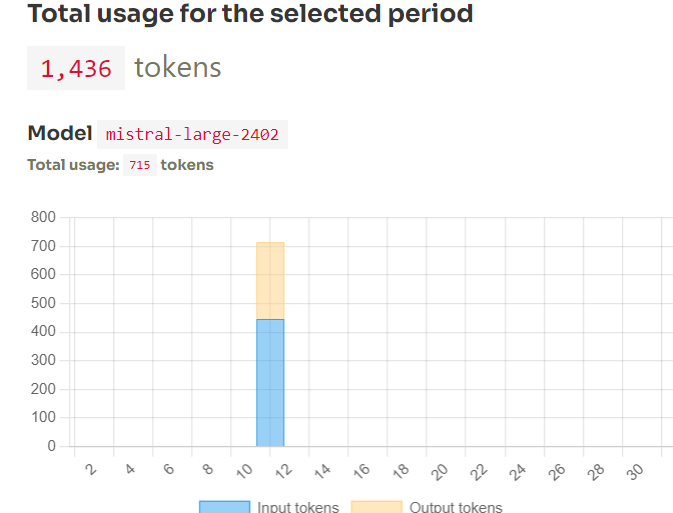

## Using OpenAI as LLM

In [156]:
agent_worker = FunctionCallingAgentWorker.from_tools(tool_retriever=obj_retriever,
                                                     llm=llm,
                                                     system_prompt="""You are an agent designed to answer queries over a set of given papers.
                                                     Please always use the tools provided to answer a question.Do not rely on prior knowledge.""",
                                                     verbose=True)
agent = AgentRunner(agent_worker)

In [158]:
response = agent.query("Summarize the paper corrective RAG.")
print(str(response))

Added user message to memory: Summarize the paper corrective RAG.
=== Calling Function ===
Calling function: summary_tool_RAG_arxiv with args: {"input": "corrective RAG"}
=== Function Output ===
The corrective RAG approach is a method used to address issues or errors in a system by categorizing them into three levels: Red, Amber, and Green. Red signifies critical problems that need immediate attention, Amber indicates issues that require monitoring or action in the near future, and Green represents no significant concerns. This approach helps prioritize and manage corrective actions effectively based on the severity of the identified issues.
=== LLM Response ===
The corrective RAG approach categorizes issues into Red, Amber, and Green levels to prioritize and manage corrective actions effectively based on severity. Red signifies critical problems needing immediate attention, Amber requires monitoring or action soon, and Green indicates no significant concerns.
assistant: The corrective